In [41]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

In [42]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [43]:
C = dde.Variable(2.0)

In [44]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return (
        dy_t
        - C * dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )

In [45]:
def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

In [46]:
bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

In [34]:
observe_x = np.vstack((np.linspace(-1, 1, num=10), np.full((10), 1))).T
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)

In [35]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic, observe_y],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    anchors=observe_x,
    solution=func,
    num_test=10000,
)

In [36]:
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [37]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"], external_trainable_variables=C)

Compiling model...
'compile' took 0.001559 s



In [38]:
variable = dde.callbacks.VariableValue(C, period=1000)
losshistory, train_state = model.train(iterations=50000, callbacks=[variable])

Training model...



d:\setup_position_1\anaconda\envs\DeepXDE\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Step      Train loss                                  Test loss                                   Test metric   
0         [1.15e+01, 1.77e+00, 1.39e-01, 9.84e-01]    [1.32e+01, 1.77e+00, 1.39e-01, 9.84e-01]    [1.54e+00]    
0 [2.00e+00]
1000      [5.81e-03, 2.52e-02, 5.06e-02, 1.76e-02]    [6.33e-03, 2.52e-02, 5.06e-02, 1.76e-02]    [3.98e-01]    
1000 [2.01e+00]
2000      [2.21e-03, 6.28e-03, 1.48e-02, 7.94e-03]    [3.68e-03, 6.28e-03, 1.48e-02, 7.94e-03]    [3.99e-01]    
2000 [1.71e+00]
3000      [7.43e-04, 1.65e-03, 3.12e-03, 3.57e-03]    [1.65e-03, 1.65e-03, 3.12e-03, 3.57e-03]    [2.67e-01]    
3000 [1.39e+00]
4000      [2.51e-04, 3.50e-04, 9.48e-05, 6.10e-04]    [9.96e-04, 3.50e-04, 9.48e-05, 6.10e-04]    [1.07e-01]    
4000 [1.13e+00]
5000      [3.73e-04, 1.51e-04, 1.37e-05, 9.49e-05]    [6.21e-04, 1.51e-04, 1.37e-05, 9.49e-05]    [3.68e-02]    
5000 [1.04e+00]
6000      [1.79e-04, 7.52e-05, 8.92e-06, 1.56e-05]    [3.80e-04, 7.52e-05, 8.92e-06, 1.56e-05]    [1.76e-02]    
600

In [40]:
C

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.9983972>

Saving loss history to e:\acedemic_remake\My_Version\Helmholtz\deepxde_wave_inverse\loss.dat ...
Saving training data to e:\acedemic_remake\My_Version\Helmholtz\deepxde_wave_inverse\train.dat ...
Saving test data to e:\acedemic_remake\My_Version\Helmholtz\deepxde_wave_inverse\test.dat ...


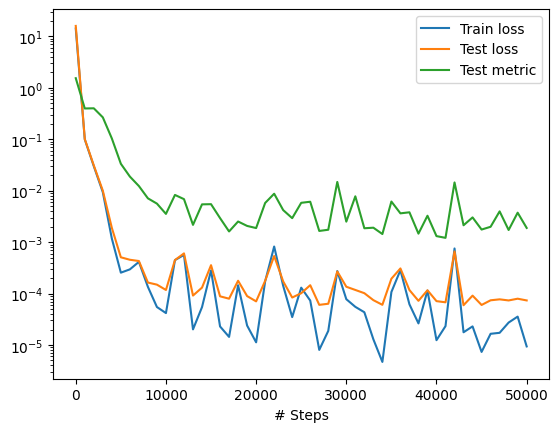

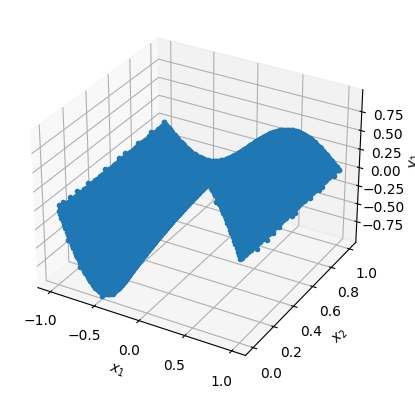

In [19]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)